# 🌿 Plant Disease Classification — Custom CNN (Subset)

This notebook is designed to run in a **local web Jupyter Notebook** (Anaconda/JupyterLab/Jupyter Notebook) on Windows 10.

**Mode:** Subset — we will create a smaller dataset by sampling up to `max_images_per_class` images per class to keep training fast on CPU.

**Model:** Custom lightweight CNN (built from scratch) — simpler and faster to train on CPU.

---

### Notes before running
1. Install required packages if missing: `pip install tensorflow opendatasets matplotlib seaborn scikit-learn`
2. For automatic Kaggle download via `opendatasets`, place your `kaggle.json` at `~/.kaggle/kaggle.json`.
   - If you don't want to use the Kaggle API, download the dataset manually from Kaggle and extract to `plantdisease/PlantVillage`.
3. Run cells from top to bottom. Adjust `max_images_per_class` and `IMG_SIZE` for speed/accuracy tradeoffs.


In [1]:
# === Configuration ===
USE_SUBSET = True
max_images_per_class = 120  # reduce to 50 for even faster runs
random_seed = 42

DATA_ROOT = 'plantdisease'
ORIG_DATA_DIR = DATA_ROOT + '/PlantVillage'
SUBSET_DIR = DATA_ROOT + '/subset'
FULL_DIR = DATA_ROOT + '/full'

print('Subset mode:', USE_SUBSET)
print('Max images per class:', max_images_per_class)

Subset mode: True
Max images per class: 120


In [2]:
# Uncomment the pip install line if you need to install packages
!pip install tensorflow opendatasets matplotlib seaborn scikit-learn --quiet

In [3]:
# === Install / Import Dependencies ===

import os
import shutil
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import opendatasets as od

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
random.seed(random_seed)
np.random.seed(random_seed)
print('TensorFlow version:', tf.__version__)
Path(DATA_ROOT).mkdir(parents=True, exist_ok=True)
print('Data root folder:', DATA_ROOT)

TensorFlow version: 2.20.0
Data root folder: plantdisease


In [4]:
# === Download dataset from Kaggle (optional) ===
# If you already downloaded the dataset, this will be skipped.
if not Path(ORIG_DATA_DIR).exists():
    print('Attempting to download PlantVillage from Kaggle via opendatasets...')
    try:
        od.download('https://www.kaggle.com/datasets/emmarex/plantdisease')
        print('Downloaded. Check folder:', ORIG_DATA_DIR)
    except Exception as e:
        print('Download failed or Kaggle not configured. Please manually download and extract to:', ORIG_DATA_DIR)
        print('Error:', e)
else:
    print('Found dataset at', ORIG_DATA_DIR)

# Show sample folders
if Path(ORIG_DATA_DIR).exists():
    sample = list(Path(ORIG_DATA_DIR).iterdir())[:8]
    print('Sample classes:', [p.name for p in sample])
else:
    print('Dataset not available yet. After placing the dataset, re-run this cell.')

Attempting to download PlantVillage from Kaggle via opendatasets...
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 658M/658M [00:07<00:00, 87.7MB/s]



Downloaded. Check folder: plantdisease/PlantVillage
Sample classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight']


In [5]:
# === Create subset (balanced) ===
orig = Path(ORIG_DATA_DIR)
subset = Path(SUBSET_DIR)

if not orig.exists():
    print('Original dataset not found at', orig)
else:
    if USE_SUBSET:
        if subset.exists():
            print('Subset exists — removing and recreating.')
            shutil.rmtree(subset)
        subset.mkdir(parents=True, exist_ok=True)
        classes = [p for p in orig.iterdir() if p.is_dir()]
        print('Found', len(classes), 'classes in original dataset.')
        for cls in classes:
            files = list(cls.glob('*'))
            if len(files) == 0:
                continue
            random.shuffle(files)
            chosen = files[:max_images_per_class]
            dst = subset / cls.name
            dst.mkdir(parents=True, exist_ok=True)
            for f in chosen:
                try:
                    shutil.copy(f, dst / f.name)
                except Exception:
                    pass
        print('Subset created at', subset)
    else:
        print('Using full dataset at', orig)
        subset = orig
        SUBSET_DIR = str(subset)

print('SUBSET_DIR =', SUBSET_DIR)

Found 16 classes in original dataset.
Subset created at plantdisease\subset
SUBSET_DIR = plantdisease/subset


In [6]:
# === Inspect subset counts ===
from collections import Counter

def counts(path):
    p = Path(path)
    if not p.exists():
        return {}
    return {c.name: len(list(c.glob('*'))) for c in p.iterdir() if c.is_dir()}

cnt = counts(SUBSET_DIR)
print('Classes in subset:', len(cnt))
# show top 10 classes by count
for i, (k,v) in enumerate(sorted(cnt.items(), key=lambda x:-x[1])[:10]):
    print(f'{i+1}. {k}: {v} images')

if len(cnt) == 0:
    print('\nNo images found in subset. Ensure ORIG_DATA_DIR is correct and dataset is downloaded.')

Classes in subset: 16
1. Pepper__bell___Bacterial_spot: 120 images
2. Pepper__bell___healthy: 120 images
3. Potato___Early_blight: 120 images
4. Potato___healthy: 120 images
5. Potato___Late_blight: 120 images
6. Tomato_Bacterial_spot: 120 images
7. Tomato_Early_blight: 120 images
8. Tomato_healthy: 120 images
9. Tomato_Late_blight: 120 images
10. Tomato_Leaf_Mold: 120 images


In [7]:
# === Prepare Image Data Generators ===
BATCH_SIZE = 16
IMG_SIZE = (128,128)  # smaller size for faster CPU training

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    SUBSET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    SUBSET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())
print('Found classes:', len(class_labels))

Found 1440 images belonging to 16 classes.
Found 360 images belonging to 16 classes.
Found classes: 16


In [8]:
# === Build Custom CNN ===
num_classes = len(class_labels)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,521,040 (24.88 MB)

 Trainable params: 6,520,592 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# === Train model ===
EPOCHS = 8
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
chk = ModelCheckpoint('best_custom_cnn.keras', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[es, chk]
)

print('Training complete')

Epoch 1/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 68s 678ms/step - accuracy: 0.1340 - loss: 5.3846 - val_accuracy: 0.0667 - val_loss: 29.9075
Epoch 2/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 62s 693ms/step - accuracy: 0.1701 - loss: 2.7392 - val_accuracy: 0.0667 - val_loss: 25.1975
Epoch 3/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 639ms/step - accuracy: 0.2188 - loss: 2.5673 - val_accuracy: 0.1000 - val_loss: 8.2093
Epoch 4/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 595ms/step - accuracy: 0.2111 - loss: 2.6386 - val_accuracy: 0.1417 - val_loss: 5.1477
Epoch 5/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 573ms/step - accuracy: 0.2326 - loss: 2.5663 - val_accuracy: 0.1583 - val_loss: 5.3174
Epoch 6/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 603ms/step - accuracy: 0.2167 - loss: 2.5099 - val_accuracy: 0.1806 - val_loss: 3.3007
Epoch 7/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 639ms/step - accuracy: 0.2299 - loss: 2.4904 - val_accuracy: 0.2667 - val_loss: 2.4256
Epoch 8/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 660ms/step - accuracy: 0.2493 - loss: 2.4309 - val_accuracy: 

In [11]:
# Automatically get class labels from the generator
class_labels = list(val_generator.class_indices.keys())

# Make sure lengths match
print(f"Number of classes in generator: {len(class_labels)}")
print(f"Unique labels in y_true: {len(np.unique(y_true))}")

# Fix mismatch if needed
if len(np.unique(y_true)) != len(class_labels):
    print("⚠️ Mismatch detected — adjusting class labels...")
    class_labels = [label for i, label in enumerate(class_labels) if i in np.unique(y_true)]


Number of classes in generator: 16
Unique labels in y_true: 15
⚠️ Mismatch detected — adjusting class labels...


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.2750 - loss: 2.3350
Validation accuracy: 0.2750
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.08      0.04      0.06        24
                     Pepper__bell___healthy       0.00      0.00      0.00        24
                      Potato___Early_blight       0.63      0.79      0.70        24
                       Potato___Late_blight       0.00      0.00      0.00        24
                           Potato___healthy       0.20      0.04      0.07        24
                      Tomato_Bacterial_spot       0.06      0.04      0.05        24
                        Tomato_Early_blight       0.00      0.00      0.00        24
                         Tomato_Late_blight       0.71      0.21      0.32        24
                           Tomato_Leaf_Mold       0.50      0.08 

C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

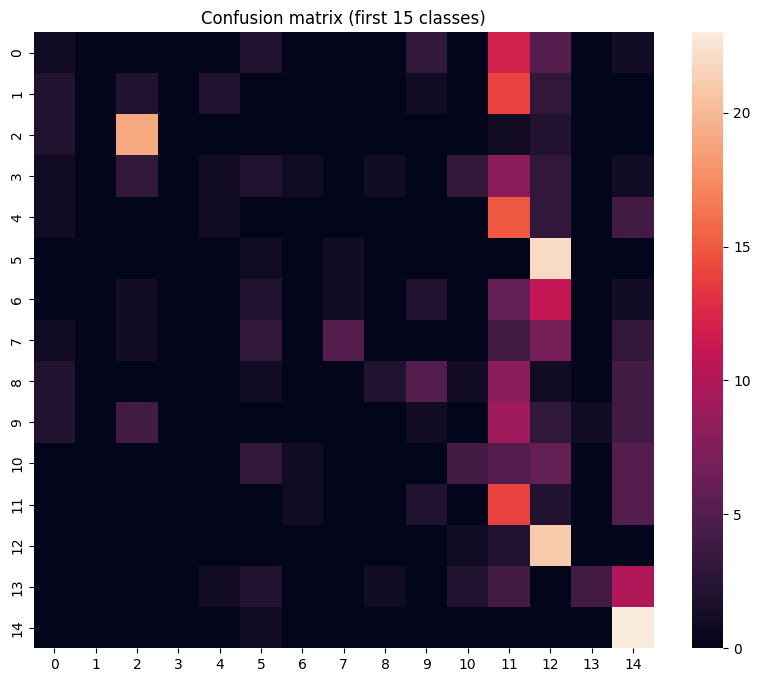

In [12]:
# === Evaluation ===
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.4f}')

val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator, verbose=1), axis=1)

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix for up to 15 classes
N = min(15, len(class_labels))
plt.figure(figsize=(10,8))
sns.heatmap(cm[:N,:N], annot=False)
plt.title('Confusion matrix (first %d classes)' % N)
plt.show()

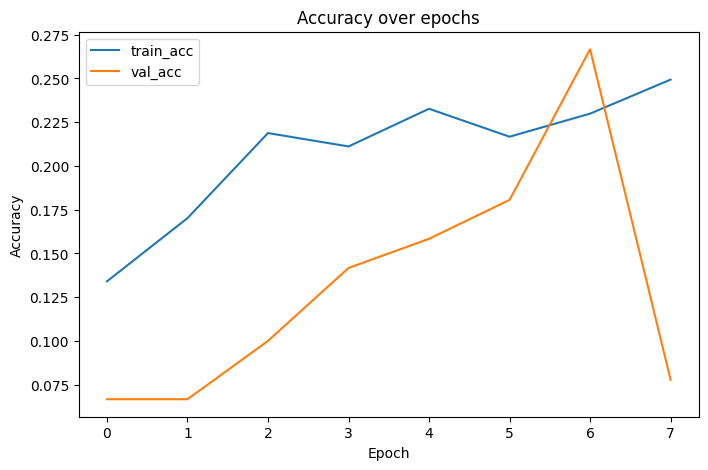

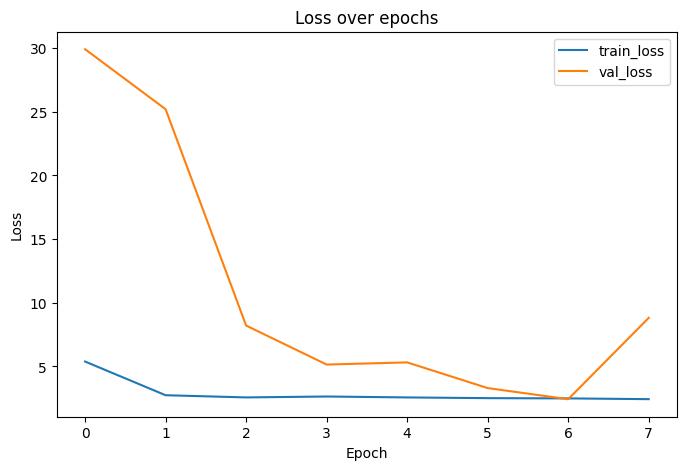

In [13]:
# === Training Curves ===
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [14]:
# === Save final model ===
model.save('plant_disease_custom_cnn_subset.keras')
print('Saved model to plant_disease_custom_cnn_subset.keras')

Saved model to plant_disease_custom_cnn_subset.keras


## Next steps & recommendations

- To further improve accuracy: increase `max_images_per_class`, increase `IMG_SIZE`, or move to transfer learning.
- Use Grad-CAM to visualize what the model focuses on for predictions.
- Consider class rebalancing or collecting more data for confused classes.

---

*End of notebook.*